# Quick Taxi Data Analysis Example (super basic)

**Data from the [DC open data portal](http://opendata.dc.gov/datasets?q=taxi])**

* **This notebook processes taxi data from a 1 month period.**

* **Data were downloaded as zipped csv files for 2017. When unzipped, it contained csv files for each month seperately.**
* **The csv for January 2017 was loaded into QGIS over a D.C. census tract shape file. To output Dropoff data, the points were loaded according to Dropoff GPS data. **
* **Dropoff dataset loaded in QGIS were then joined with D.C. census tracts such that each Dropoff row now had Census tract number and land area. **
* **Dataset was then saved with the convention "yearmonth_dropoff.csv"**

** This project explores fares across D.C. census tracts and payment types and trip types.**

`TRIPTYPE` is "DDS" for Digital Dispatch Service, which includes phone dispatch; "PSP" for street hail, and "Transport-DC" for Metro Access.

## Import all libraries and set up 

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Style charts
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'

# Set display parameters
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

## Read in pick-up data and take a look

In [2]:
dropoff = pd.read_csv('../data/processed/dropoff.csv')

Check columns

In [3]:
print("dropoff", dropoff.columns)

dropoff Index(['TRIPTYPE', 'METERFARE', 'TIP', 'TOTALAMOUN', 'PAYMENTTYP', 'PAYMENTCAR', 'DROPOFFDAT', 'GEOID10', 'NAME10', 'ALAND10', 'GEOID'], dtype='object')


In [4]:
dropoff.head()

,TRIPTYPE,METERFARE,TIP,TOTALAMOUN,PAYMENTTYP,PAYMENTCAR,DROPOFFDAT,GEOID10,NAME10,ALAND10,GEOID
0,PSP,6.49,2.0,8.74,CreditCard,AmericanExpress,02/21/2016 00:00,11001004300,43.0,236646,11001004300
1,PSP,6.22,1.5,7.97,CreditCard,MasterCardCredit,02/26/2016 12:00,11001010200,102.0,1239830,11001010200
2,PSP,6.22,0.0,6.47,Cash,Cash,02/26/2016 14:00,11001010600,106.0,1236709,11001010600
3,PSP,10.00,0.0,10.25,Cash,Cash,02/26/2016 13:00,11001010600,106.0,1236709,11001010600
4,PSP,7.03,0.0,7.28,Cash,Cash,02/20/2016 20:00,11001005800,58.0,910808,11001005800


Check length (how many rows, or taxi trips)

In [5]:
# Find number of rows of data
print(len(dropoff))

10682845


## Examine and Clean data

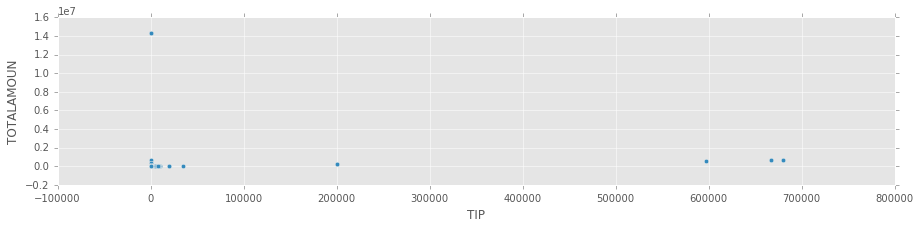

In [6]:
dropoff.plot.scatter(x='TIP', y='TOTALAMOUN')

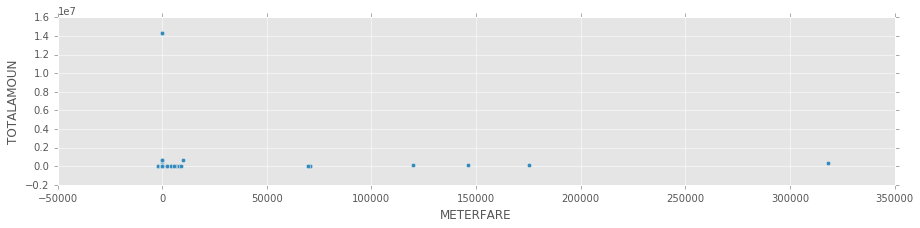

In [7]:
dropoff.plot.scatter(x='METERFARE', y='TOTALAMOUN')

Because there are some mistakes in the data, it was filtered to only include rows where `TOTALAMOUN`, `TIP`, and `METERFARE` are all under 100 dollars, are not less than 0, and so that `TIP` and `METERFARE` are not more than `TOTALAOUN`, and does not contain fares that are of `TRIPTYPE` `"Transport-DC"`

In [15]:
data = dropoff[dropoff.METERFARE < 100]
data = data[data.TOTALAMOUN < 100]
data = data[data.TIP < 100]
data = data[data.METERFARE > 0]
data = data[data.TIP > 0]
data = data[data.TOTALAMOUN > 0]
data = data[data.TIP < data.TOTALAMOUN]
data = data[data.METERFARE < data.TOTALAMOUN]
data = data[data.TRIPTYPE != 'TRANSPORT-DC']

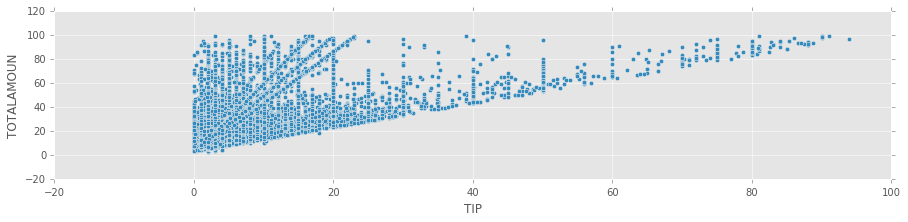

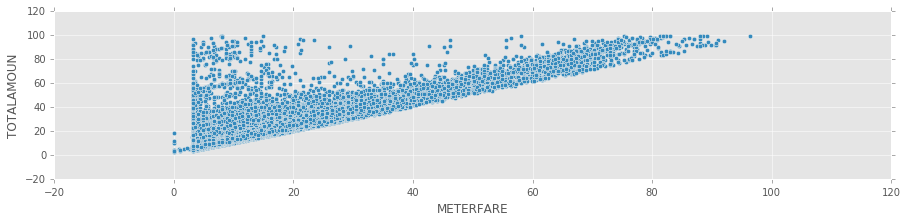

In [9]:
data.plot.scatter(x='TIP', y='TOTALAMOUN')
data.plot.scatter(x='METERFARE', y='TOTALAMOUN')

In [10]:
# Check number of rows after cleaning
len(data)

3881586

### Get means and medians for METERFARE, TIP and TOTOLAMOUNT when TRIPTYPE is DDS (digital or phone call hail) or PSP (street hail)

In [41]:
print("DDS: METERFARE mean: ", data[data.TRIPTYPE == 'DDS'].METERFARE.mean())
print("PSP: METERFARE mean: ", data[data.TRIPTYPE == 'PSP'].METERFARE.mean())

print("DDS: METERFARE median: ", data[data.TRIPTYPE == 'DDS'].METERFARE.median())
print("PSP: METERFARE median: ", data[data.TRIPTYPE == 'PSP'].METERFARE.median())

print("DDS: TIP mean: ", data[data.TRIPTYPE == 'DDS'].TIP.mean())
print("PSP: TIP medan: ", data[data.TRIPTYPE == 'PSP'].TIP.mean())

print("DDS: TIP median: ", data[data.TRIPTYPE == 'DDS'].TIP.median())
print("PSP: TIP median: ", data[data.TRIPTYPE == 'PSP'].TIP.median())

print("DDS: TOTALAMOUNT mean: ", data[data.TRIPTYPE == 'DDS'].TOTALAMOUN.mean())
print("PSP: TOTALAMOUNT mean: ", data[data.TRIPTYPE == 'PSP'].TOTALAMOUN.mean())

print("DDS: TOTALAMOUNT median: ", data[data.TRIPTYPE == 'DDS'].TOTALAMOUN.median())
print("PSP: TOTALAMOUNT median: ", data[data.TRIPTYPE == 'PSP'].TOTALAMOUN.median())

DDS: METERFARE mean:  12.840482103345307
PSP: METERFARE mean:  9.9677748325871
DDS: METERFARE median:  12.16
PSP: METERFARE median:  8.92
DDS: TIP mean:  3.2069301054275505
PSP: TIP medan:  2.5413966632177942
DDS: TIP median:  3.0
PSP: TIP median:  2.06
DDS: TOTALAMOUNT mean:  18.25361369256811
PSP: TOTALAMOUNT mean:  13.329251986707119
DDS: TOTALAMOUNT median:  17.52
PSP: TOTALAMOUNT median:  11.94


### Create new data table collapsing all all data within each D.C. census tract

Each colum will be for average METERFARE, average TIP and average TOTAL AMOUNT, for trips paid for by CASH or CREDITCARD, and cabs hailed digitally or by phone (DDS) or by street hail (PSP)

In [49]:
def merge_toTracts(tmp, i):
        
    tmp_dict = {}
        
#     tmp_dict['DDS_taxi_sum'] = (tmp[tmp.TRIPTYPE=='DDS'].)
#     tmp_dict['PSP_taxi_sum'] = len(tmp[tmp.dropoff.TRIPTYPE=='PSP'].sum)
    
    tmp_dict['DDS_cash_meterfare_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='DDS') & (tmp.PAYMENTTYP=='Cash')].METERFARE)
    tmp_dict['DDS_creditcard_meterfare_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='DDS') & (tmp.PAYMENTTYP=='CreditCard')].METERFARE)
    tmp_dict['PSP_cash_meterfare_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='PSP') & (tmp.PAYMENTTYP=='Cash')].METERFARE)
    tmp_dict['PSP_creditcard_meterfare_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='PSP') & (tmp.PAYMENTTYP=='CreditCard')].METERFARE)

    tmp_dict['DDS_cash_total_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='DDS') & (tmp.PAYMENTTYP=='Cash')].TOTALAMOUN)
    tmp_dict['DDS_creditcard_total_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='DDS') & (tmp.PAYMENTTYP=='CreditCard')].TOTALAMOUN)
    tmp_dict['PSP_cash_total_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='PSP') & (tmp.PAYMENTTYP=='Cash')].TOTALAMOUN)
    tmp_dict['PSP_creditcard_total_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='PSP') & (tmp.PAYMENTTYP=='CreditCard')].TOTALAMOUN)

    tmp_dict['DDS_cash_tip_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='DDS') & (tmp.PAYMENTTYP=='Cash')].TIP)
    tmp_dict['DDS_creditcard_tip_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='DDS') & (tmp.PAYMENTTYP=='CreditCard')].TIP)
    tmp_dict['PSP_cash_tip_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='PSP') & (tmp.PAYMENTTYP=='Cash')].TIP)
    tmp_dict['PSP_creditcard_tip_mean'] = np.mean(tmp[(tmp.TRIPTYPE=='PSP') & (tmp.PAYMENTTYP=='CreditCard')].TIP)

    tmp_dict['GEOID'] = i

    return tmp_dict

In [50]:
consolidated_tracts = []

def get_merged(df):
    for i in df.GEOID10.unique():
        tmp = df[df.GEOID10 == i]
        consolidated_tracts.append(merge_toTracts(tmp, i))
        
#get_merged_locations(places_tracts)
get_merged(data)

In [51]:
consolidated_tracts

[{'DDS_cash_meterfare_mean': 10.585,
  'DDS_cash_tip_mean': 1.9733333333333334,
  'DDS_cash_total_mean': 14.891666666666666,
  'DDS_creditcard_meterfare_mean': 10.941432506887065,
  'DDS_creditcard_tip_mean': 2.8228099173553716,
  'DDS_creditcard_total_mean': 15.629944903581276,
  'GEOID': 11001004300,
  'PSP_cash_meterfare_mean': 7.4981565600882,
  'PSP_cash_tip_mean': 2.953925027563397,
  'PSP_cash_total_mean': 11.161232635060616,
  'PSP_creditcard_meterfare_mean': 8.78550837889894,
  'PSP_creditcard_tip_mean': 2.151385562172115,
  'PSP_creditcard_total_mean': 11.647073473092313},
 {'DDS_cash_meterfare_mean': 12.073599999999999,
  'DDS_cash_tip_mean': 2.8708000000000005,
  'DDS_cash_total_mean': 17.2744,
  'DDS_creditcard_meterfare_mean': 11.883193277310939,
  'DDS_creditcard_tip_mean': 3.047599039615844,
  'DDS_creditcard_total_mean': 17.072749099639857,
  'GEOID': 11001010200,
  'PSP_cash_meterfare_mean': 8.759433794466414,
  'PSP_cash_tip_mean': 3.0743389328063273,
  'PSP_cash_tot

In [52]:
dropoff_tracts = pd.DataFrame(consolidated_tracts)

In [53]:
dropoff_tracts.head()

,DDS_cash_meterfare_mean,DDS_cash_tip_mean,DDS_cash_total_mean,DDS_creditcard_meterfare_mean,DDS_creditcard_tip_mean,DDS_creditcard_total_mean,GEOID,PSP_cash_meterfare_mean,PSP_cash_tip_mean,PSP_cash_total_mean,PSP_creditcard_meterfare_mean,PSP_creditcard_tip_mean,PSP_creditcard_total_mean
0,10.585000,1.973333,14.891667,10.941433,2.822810,15.629945,11001004300,7.498157,2.953925,11.161233,8.785508,2.151386,11.647073
1,12.073600,2.870800,17.274400,11.883193,3.047599,17.072749,11001010200,8.759434,3.074339,12.832099,9.833136,2.464807,13.164311
2,11.260000,1.465000,14.891667,13.000759,2.974684,18.136835,11001003100,8.449694,3.009915,12.086076,10.350315,2.405459,13.442200
3,12.331818,3.327727,18.136818,12.729894,3.824809,18.684489,11001000202,9.357789,3.098204,13.352126,10.978469,2.555176,14.342727
4,11.192500,1.886250,15.453750,11.515475,2.997179,16.488715,11001004400,7.854540,2.980375,11.570876,9.000469,2.221132,11.979526


In [59]:
# Check length matches the number of D.C. census tracts
len(dropoff_tracts)

179

# Visualizing other data characteristics

In [42]:
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

In [55]:
dropoff_tracts.columns

Index(['DDS_cash_meterfare_mean', 'DDS_cash_tip_mean', 'DDS_cash_total_mean', 'DDS_creditcard_meterfare_mean', 'DDS_creditcard_tip_mean', 'DDS_creditcard_total_mean', 'GEOID', 'PSP_cash_meterfare_mean', 'PSP_cash_tip_mean', 'PSP_cash_total_mean', 'PSP_creditcard_meterfare_mean', 'PSP_creditcard_tip_mean', 'PSP_creditcard_total_mean'], dtype='object')

In [56]:
cols = ['DDS_cash_meterfare_mean', 
        'DDS_creditcard_meterfare_mean',
        'DDS_cash_tip_mean', 
        'DDS_creditcard_tip_mean',
        'DDS_cash_total_mean', 
        'DDS_creditcard_total_mean', 
        'PSP_cash_meterfare_mean', 
        'PSP_creditcard_meterfare_mean',
        'PSP_cash_tip_mean', 
        'PSP_creditcard_tip_mean', 
        'PSP_cash_total_mean',  
        'PSP_creditcard_total_mean']

### Look at the correlation between each measure across 179 D.C. census tracts.

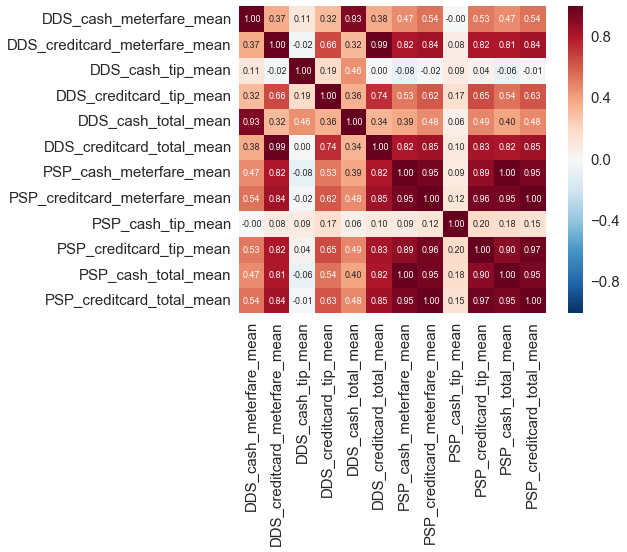

In [57]:
tmp = dropoff_tracts.dropna()
cm = np.corrcoef(tmp[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':9}, yticklabels=cols, xticklabels=cols)
plt.show()

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/jenniferstark/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


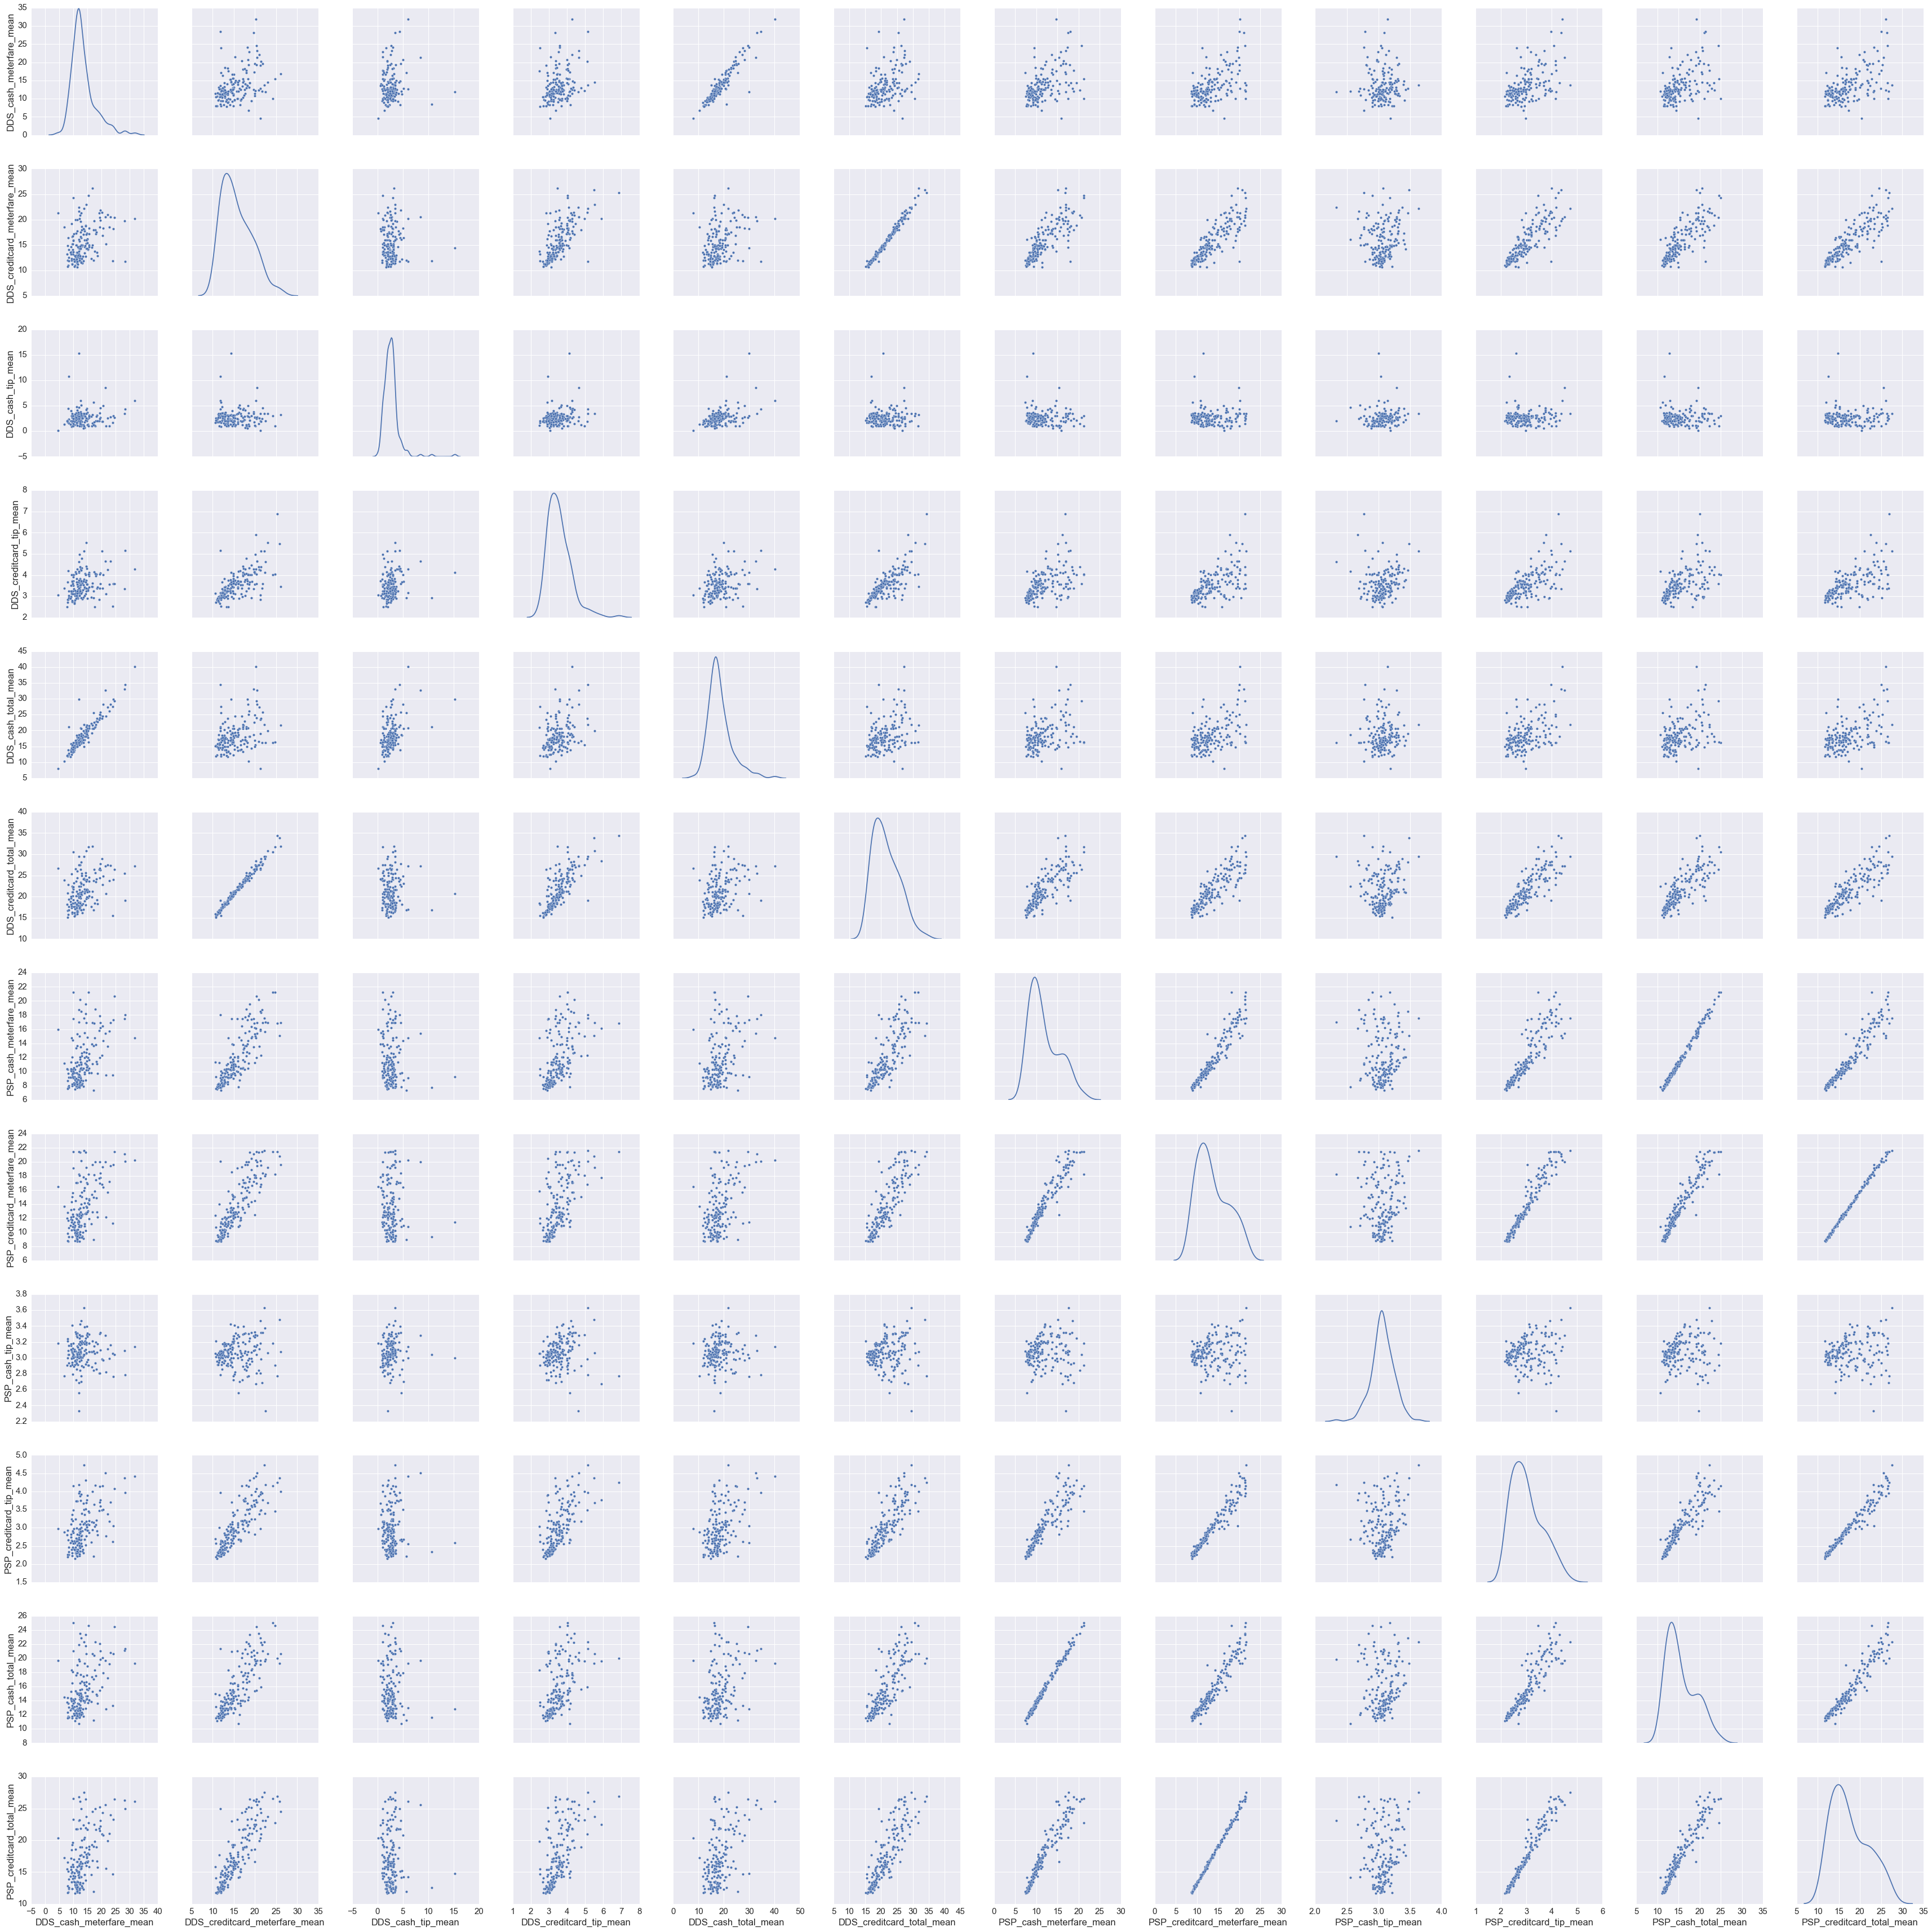

In [58]:
sns.pairplot(dropoff_tracts[cols], diag_kind='kde', size=4)